# CAM 활용하기
ResNet-18의 feature map을 활용해 CAM구현.  
-> CAM은 Average pooling 적용 전의 feature map을 활용한다.

In [1]:
#ResNet-18 모델 특징 추출
from torch import nn
from torchvision import models

model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()
features = nn.Sequential(*list(model.children())[:-2]) # 마지막 계층을 제외한 특징 추출
#ResNet구조는 input stem, 네 개의 layer, avgpool, fc으로 구성되어 있다. 그러므로 avgpooling과 fc는 classifier이므로 슬라이싱 처리해 추출하여 features로 저장

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s]


In [7]:
#피쳐 맵과 가중치 추출
from PIL import Image
from torchvision import transforms

transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

image = Image.open("/content/drive/MyDrive/data/airplane.jpg")
target = transform(image).unsqueeze(0)

output = model(target)
class_idx = int(output.argmax())

weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [11]:
# create a class activation map
import torch
from torch.nn import functional as F

cam = features_output * weights #class_idx에 해당하는 채널별 이미지 영역의 중요 특징이 계산된다.
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0), # 언스퀴즈를 통해 차원을 확장
    size=(image.size[1], image.size[0]), # cam을 이미지 크기와 동일한 크기로 변경한다.
    mode="bilinear" #이중 선형 보간을 통해 부드러운 확장
).squeeze().detach().numpy()

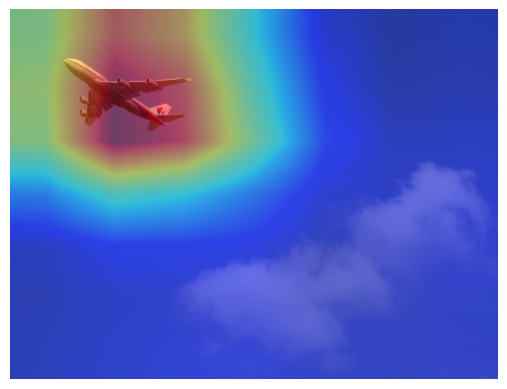

In [12]:
# Class Activation Map Visualization
import matplotlib.pyplot as plt

plt.imshow(image)
plt.imshow(cam, alpha=0.5, cmap="jet")
plt.axis("off")
plt.show()

## Result
비행기 클래스로 분류하기 위해 어떤 영역을 중점적으로 바라보는지 알 수 있다.  
CAM
c
​
 =
k
∑
​
 w
k
c
​
 ⋅f
k
​

## Advanced Task
### Grad-CAM.
CAM과 유사하지만 grobal average pooling을 쓰지 않고 last conv layer에서 back prop을 통해 class의 importance calculation한다.  
Grad-CAM
c
​
 =ReLU(
k
∑
​
 α
k
c
​
 ⋅f
k
​
 )


ResNet18과 Hook를 활용한다.  *hook: 특정 이벤트가 발생했을 때 다른 코드를 실행하는 기술.  
마지막 conv layer의 forward와 backward를 활용하므로 해당 계층이 실행될 때 이벤트를 실행시켜 기울기를 얻는다.

In [15]:
#apply grad-cam
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    def register_hook(self, main, sub): # 하위 모듈을 검색한다.그리고 main과 sub가 동일한 계층을 찾고 hook을 등록한다.
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output

    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]

        # Create Grad-Cam
    def __call__(self, x):
        output = self.model(x)

        index = output.argmax(axis=1)
        one_hot = torch.zeros_like(output)
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(a_k * self.feature_map, dim=1)
        grad_cam = torch.relu(grad_cam)
        return grad_cam

### Visualization


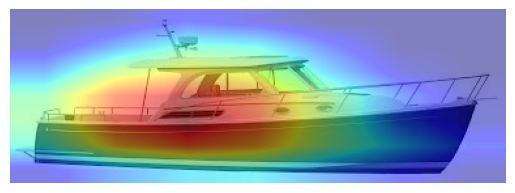

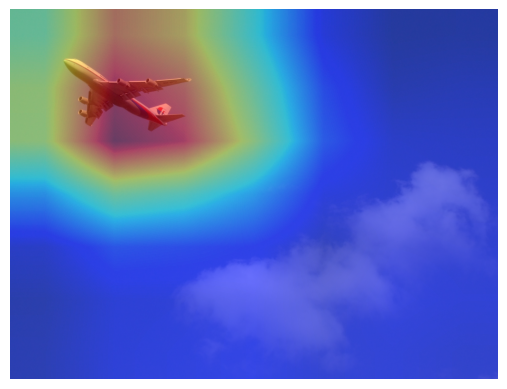

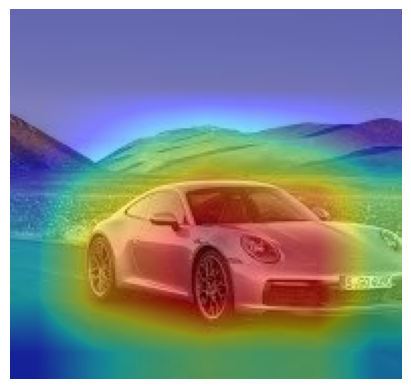

In [19]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "/content/drive/MyDrive/data/boat.jpeg", "/content/drive/MyDrive/data/airplane.jpg",
    "/content/drive/MyDrive/data/porche.jpeg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()

## Summary


- CAM:

Requires a specific network architecture with a global average pooling layer followed by a fully connected layer.
Uses weights from the final layer to generate class activation maps.
Simpler but less flexible and less detailed.  

- Grad-CAM:

Can be applied to a wide variety of CNN architectures.
Uses gradients of the target class to weight feature maps, providing better localization and sensitivity to details.
More complex but offers greater flexibility and more detailed visualizations.